In [38]:
%matplotlib inline
import random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

df = pd.read_csv('DellGSPE_DSrole_dataset.csv')

# Preliminary EDA

In [2]:
# Checking % of NA's by column

pct_nan=[]
pct_nan_name=[]

for col in df.columns:
    pct_nan_name.append([col,sum(df[col].isna())/len(df[col])])
    pct_nan.append(sum(df[col].isna())/len(df[col]))

pct_nan_name

[['asst_id', 0.0],
 ['product_type', 0.0002],
 ['mnfture_wk', 0.0],
 ['contract_st', 0.0],
 ['contract_end', 0.0],
 ['contact_wk', 0.0],
 ['contact_type', 0.00014],
 ['issue_type', 0.14042],
 ['topic_category', 0.33084],
 ['parts_sent', 0.45434],
 ['repair_type', 0.0],
 ['repeat_ct', 0.0],
 ['parts_ct', 0.0],
 ['agent_tenure_indays', 0.00014],
 ['contact_manager_flg', 0.0],
 ['diagnostics', 0.0],
 ['repeat_parts_sent', 0.86654],
 ['region', 3e-05],
 ['country', 0.10002]]

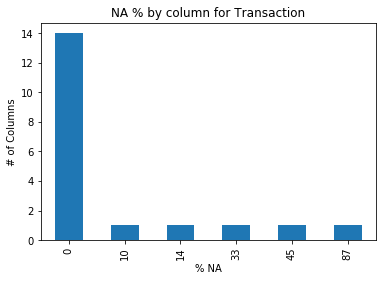

In [3]:
plot_nan = round((pd.Series(pct_nan))*100,0).map(int)

x = plot_nan.value_counts().sort_index()
x.plot(kind='bar')
plt.ylabel('# of Columns')
plt.xlabel('% NA')
plt.title('NA % by column for Transaction')
plt.show()

In [4]:
# Looking at the details of the features

for col, values in df.iteritems():
    num_uniques = values.nunique()
    print ('{name}: {num_unique}'.format(name=col, num_unique=num_uniques))
    print (values.unique())
    print ('\n')

asst_id: 82442
[    0     1     2 ... 82439 82440 82441]


product_type: 3
['Laptops' 'Desktops' 'Other Electronics' nan]


mnfture_wk: 497
[201726 201650 201821 201608 201732 201137 201710 201751 201638 201644
 201809 201826 201632 201617 201802 201742 201508 201823 201808 201815
 201721 201636 201616 201830 201614 201442 201640 201504 201526 201648
 201628 201814 201412 201745 201539 201525 201749 201753 201747 201828
 201702 201829 201551 201725 201844 201807 201531 201819 201612 201843
 201529 201547 201630 201625 201724 201812 201246 201639 201232 201510
 201546 201703 201641 201622 201735 201835 201104 201824 201739 201715
 201351 201532 201441 201731 201220 201609 201419 201645 201507 201520
 201744 201733 201729 201549 201634 201833 201737 201552 201822 201723
 201818 201714 201711 201719 201752 201740 201519 201603 201712 201832
 201801 201538 201618 201643 201307 201610 201717 201326 201543 201613
 201051 201806 201652 201631 201811 201839 201513 201515 201825 201730
 201151 

parts_ct: 28
[ 3  2  1  0  4  5  6 11  7 10  8 14 29 13  9 12 51 18 15 20 21 17 16 19
 28 50 46 48]


agent_tenure_indays: 1044
[1018.  298.  802. ...  558. 4750. 2632.]


contact_manager_flg: 2
[0 1]


diagnostics: 4
['Not_USED' 'Effective_Usage' 'InEffective_Usage' 'Not_Considered']


repeat_parts_sent: 1561
[nan 'Motherboard, Miscellaneous(2), Hard Drive, Chassis, Cables'
 'Motherboard, LCD Panel, Documentation, Cables' ...
 'Motherboard, Miscellaneous, Heatsink, Documentation, Cables, Adapter, AC'
 'Motherboard, Chassis(4), Cables'
 'Mouse, LCD Panel, Hard Drive, Chassis, Cables(2)']


region: 3
['Hogwarts' 'Middle Earth' 'Milky Way' nan]


country: 53
[nan "Zonko's Joke Shop" 'Lorien' 'The Shire' 'Mordor' 'Merope' 'Pollux'
 'Three Broomsticks' 'Shrieking Shack' 'Ravenclaw' 'Hufflepuff' 'Capella'
 "Honeyduke's" 'Polaris' 'Fomalhaut' 'Hobbiton' 'Sabik' 'Spica' 'Becrux'
 'Vega' 'Rohan' 'Gondor' 'Aldebaran' 'Mintaka' 'Rukbat' 'Acrux' 'Canopus'
 'Rigel' 'Antares' 'Diagon Alley' 'Gryffi

# Feature Engineering

In [39]:
import math

# replacing Nans with -99999 so they standout just like nans, but easier to use and still provide some value. 

# Scaling the 'agent_tenure_indays' to use in some classifiers later on
df['agent_tenure_indays'] = df['agent_tenure_indays'].fillna(-99999)
df['agent_tenure_indays'] = df['agent_tenure_indays'].astype(int)
df['agent_tenure_indays_s'] = df['agent_tenure_indays'].fillna(-99999)
df['agent_tenure_indays_s'] = df['agent_tenure_indays'].astype(int)
df['agent_tenure_indays_s'] = df['agent_tenure_indays']/df['agent_tenure_indays'].max()

df['repeat_flag'] = 0
df['repeat_ct_flag'] = 0
df['repeat_pt_flag'] = 0

# Creating a flag if there is a repeat visit using repeat_ct and repeat_parts sent
df['repeat_parts_sent'] = df['repeat_parts_sent'].fillna('-99999')
df['repeat_ct_flag'] = df['repeat_ct'].map(lambda x:  1 if x > 0 else 0)
df['repeat_pt_flag'] = df['repeat_parts_sent'].map(lambda x:  0 if x =='-99999' else 1)
df['flag_sum'] = df['repeat_ct_flag'] + df['repeat_pt_flag']
df['repeat_flag'] = df['flag_sum'].map(lambda x:  1 if x >0 else 0)

# Creating 3 variables to know if this contact is within the 1st or last year of the 
# contract, and how far into the contract they are when they made the call. 
df['start_yr'] = df['contract_st'].astype(str).str[:4].astype(int)
df['start_wk'] = df['contract_st'].astype(str).str[-2:].astype(int)
df['end_yr'] = df['contract_end'].astype(str).str[:4].astype(int)
df['end_wk'] = df['contract_end'].astype(str).str[-2:].astype(int)
df['contract_weeks'] = (df['end_yr'] - (df['start_yr']+1))*52 + df['end_wk'] + (52 - df['start_wk'])
df['wks_passed'] = (2018- (df['start_yr']+1))*52 + 40 + (52 - df['start_wk'])
df['wks_left'] = (df['end_yr'] -2019)*52 + df['end_wk'] + 12
df['first_yr_contact'] = df['wks_passed'].map(lambda x:  1 if x < 53 else 0)
df['last_yr_contact'] = df['wks_left'].map(lambda x:  1 if x < 53 else 0)
df['pct_complete_contract'] = round(df['wks_passed'] / df['contract_weeks'],3)

# Changing the contact values toupper to fix the Voice vs VOICE
df['contact_type'] = df['contact_type'].fillna('-99999')
df['contact_type'] = df['contact_type'].map(lambda x: x if x =='-99999' else x.upper())

# Data prep to be able to look at top parts (single parts, 2 part pairs and  3 parts?)
# Maybe try a TF-IDF logistic model 
df['parts_sent'] = df['parts_sent'].fillna('-99999')
df['repeat_parts_sent'] = df['repeat_parts_sent'].fillna('-99999')
df['parts_sent'] = df['parts_sent'].map(lambda x: x.replace(" ", "_"))
df['parts_sent'] = df['parts_sent'].map(lambda x: x.replace(",_", ", "))
df['repeat_parts_sent'] = df['repeat_parts_sent'].map(lambda x: str(x).replace(" ", "_"))
df['repeat_parts_sent'] = df['repeat_parts_sent'].map(lambda x: x.replace(",_", ", "))


# dropping the extra columns to only keep the flags.
df = df.drop(['repeat_ct_flag','repeat_pt_flag','flag_sum','start_yr','start_wk','end_yr','end_wk','contract_weeks','wks_passed','wks_left', ], axis=1)

I was interested in creating the 'repeat_flag' thinking it would be good to know what scenarios may lead to repeat contacts. If we are able to predict it, then we would better understand what to do to prevent repeat visits or be able to forecast better to plan when they will need to be visited. 

The data provides calendar weeks but those themselves do not provide much information. I'm hoping the new variables will have more predictive power. 

In [7]:
df.head()

,asst_id,product_type,mnfture_wk,contract_st,contract_end,contact_wk,contact_type,issue_type,topic_category,parts_sent,...,contact_manager_flg,diagnostics,repeat_parts_sent,region,country,agent_tenure_indays_s,repeat_flag,first_yr_contact,last_yr_contact,pct_complete_contract
0,0,Laptops,201726,201726,202125,201840,VOICE,NaN,NaN,"Hard_Drive, Documentation(2)",...,0,Not_USED,-99999,Hogwarts,NaN,0.114100,0,0,0,0.319
1,1,Laptops,201650,201650,201949,201840,VOICE,NaN,NaN,"Speaker, Chassis",...,0,Not_USED,-99999,Hogwarts,Zonko's Joke Shop,0.114100,0,0,0,0.606
2,2,Laptops,201821,201821,202222,201840,VOICE,NaN,NaN,Cables,...,0,Not_USED,"Motherboard, Miscellaneous(2), Hard_Drive, Cha...",Hogwarts,Zonko's Joke Shop,0.114100,1,1,0,0.091
3,3,Laptops,201608,201608,201908,201840,VOICE,Hard Drive,Booting,Hard_Drive,...,0,Effective_Usage,-99999,Hogwarts,Zonko's Joke Shop,0.033401,0,0,1,0.872
4,4,Laptops,201732,201732,202032,201840,VOICE,NaN,NaN,Battery_(Notebook),...,0,Not_USED,-99999,Hogwarts,Zonko's Joke Shop,0.114100,0,0,0,0.385


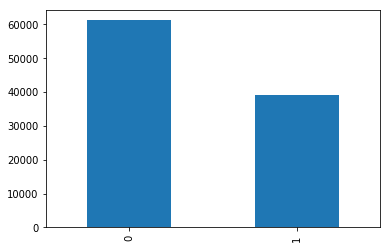

In [17]:
df['first_yr_contact'].value_counts()[:10].plot(kind='bar')

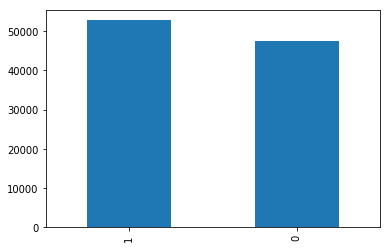

In [43]:
df['last_yr_contact'].value_counts().plot(kind='bar')

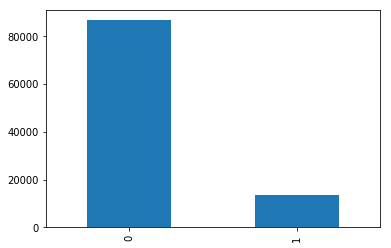

In [42]:
df['repeat_flag'].value_counts().plot(kind='bar')

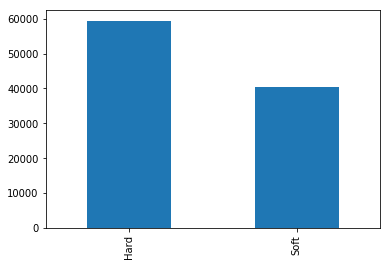

In [10]:
df['repair_type'].value_counts().plot(kind='bar')

# Run classifier for contact manager flag

The purpose of trying to predict if a call will need to go through a manager is usefull for optimizing the que. If we are able to run the model while we have callers in the que and identify which of them will most likely talk to the manager, we can send them directly to the manager to take care of the problem. With the manager's time being a lot more valuable however, we would want to minimize false positives. That is, make sure the calls we do send to the managers are calls that would get there eventually and not send a call that could have been handeled through the regular process. This would increase customer satisfaction (especially because these customers may already be frustrated), decrease the total time they spend on the line, as well as free up the front line receivers to work on cases they can close.

In [40]:
from random import sample
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score, f1_score
from sklearn.linear_model import LogisticRegression 
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from random import sample
from sklearn import preprocessing

le = preprocessing.LabelEncoder() #Encode labels with value between 0 and n_classes-1

df_encoder = df.copy()

df_encoder = df_encoder.fillna('-99999')

df_encoder['product_type']  = le.fit_transform(df_encoder['product_type'])
df_encoder['contact_type']  = le.fit_transform(df_encoder['contact_type'])
df_encoder['issue_type']  = le.fit_transform(df_encoder['issue_type'])
df_encoder['topic_category']  = le.fit_transform(df_encoder['topic_category'])
df_encoder['repair_type']  = le.fit_transform(df_encoder['repair_type'])
df_encoder['diagnostics']  = le.fit_transform(df_encoder['diagnostics'])
df_encoder['region']  = le.fit_transform(df_encoder['region'])
df_encoder['country']  = le.fit_transform(df_encoder['country'])

mask = df_encoder['contact_manager_flg'] == 1
df_encoder_1 = df_encoder[mask] #length: 1243
df_encoder_0 = df_encoder[-mask].sample(n = 8757, random_state=47)

# Create balanced data set with 1 in 10 of the minority class 
df_encoder_blncd = pd.concat([df_encoder_1, df_encoder_0])



The origional data file had only 1% of the observations going to the manager. In order to better train the model, I under sampled the data to provide a better enviroment to train the model. Also, their are a lot of categorical variables, so I encoded them to numeric labels in order to incorporate them into the models.

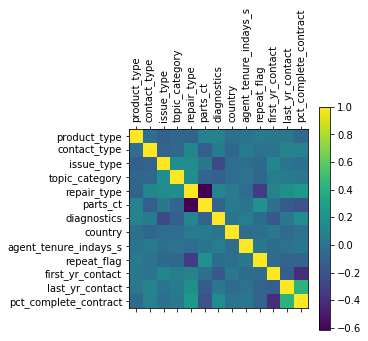

In [9]:
X2 = df_encoder.copy()
X2 = X2.drop(['asst_id','contact_manager_flg','mnfture_wk', 'contract_st', 'contract_end',
       'contact_wk','parts_sent','agent_tenure_indays','repeat_parts_sent','region','repeat_ct'],axis=1)
y2 = df_encoder['contact_manager_flg']

X = df_encoder_blncd.drop(['asst_id','contact_manager_flg','mnfture_wk', 'contract_st', 'contract_end',
       'contact_wk','parts_sent','agent_tenure_indays','repeat_parts_sent','region','repeat_ct'],axis=1)
y = df_encoder_blncd['contact_manager_flg']

X = X.replace([np.inf, -np.inf], np.nan)
X = X.fillna(-99999)
X2 = X2.replace([np.inf, -np.inf], np.nan)
X2 = X2.fillna(-99999)

plt.matshow(X.corr())
plt.xticks(range(len(X.columns)), X.columns,rotation='vertical')
plt.yticks(range(len(X.columns)), X.columns)
plt.colorbar()
plt.show()

As expected, the pct_complete_contract variable is highly correlated with the other two calendar variables. Also, Parts_ct and repair_type is highly correlated. This also makes sense because only hard repairs require parts to be sent. 

Trying different classifiers to see which will give the highest accuracy and AUCROC score (Logistic, Decision Tree, Random Forest and MLP). Training the model using the balanced data set and testing on the full. 

In [18]:
from sklearn.metrics import confusion_matrix
import sklearn.metrics as metrics

LR = LogisticRegression()

model = LR.fit(X,y)
y_pred = model.predict(X2)

print(confusion_matrix(y2,y_pred))
print('Accuracy', metrics.accuracy_score(y2,y_pred))
print('AUCROC', roc_auc_score(y2,y_pred))



[[95880  2877]
 [  867   376]]
Accuracy 0.96256
AUCROC 0.6366809270283527


C:\Users\chris\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[[95047  3710]
 [  657   586]]
Accuracy 0.95633
AUCROC 0.7169365535407204


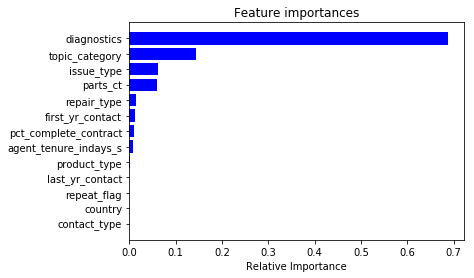

In [19]:
DT = DecisionTreeClassifier(max_depth=5, min_samples_split=6, random_state=0)

model = DT.fit(X,y)
y_pred = model.predict(X2)

print(confusion_matrix(y2,y_pred))
print('Accuracy', metrics.accuracy_score(y2,y_pred))
print('AUCROC', roc_auc_score(y2,y_pred))

features = X.columns.values
importances = model.feature_importances_

indices = np.argsort(importances)
plt.title('Feature importances')
plt.barh(range(len(indices)), importances[indices], color = 'b', align = 'center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
#plt.rcParams["figure.figsize"] = (20,10)
plt.show()

[[97224  1533]
 [  664   579]]
Accuracy 0.97803
AUCROC 0.7251427887417755


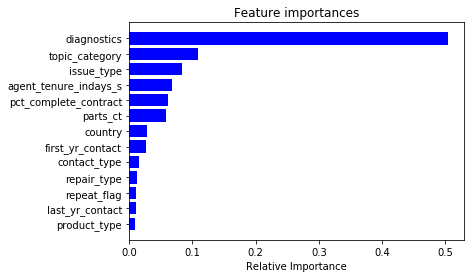

In [20]:
RF = RandomForestClassifier(n_estimators = 200, max_depth = 8, min_samples_split=6, random_state = 0)

model = RF.fit(X,y)
y_pred = model.predict(X2)

print(confusion_matrix(y2,y_pred))
print('Accuracy', metrics.accuracy_score(y2,y_pred))
print('AUCROC', roc_auc_score(y2,y_pred))

features = X.columns.values
importances = model.feature_importances_

indices = np.argsort(importances)
plt.title('Feature importances')
plt.barh(range(len(indices)), importances[indices], color = 'b', align = 'center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
#plt.rcParams["figure.figsize"] = (20,10)
plt.show()

The pct_complete_contract created earlier is in the top 5 most important variables for the random forest model.

For MLP I need to tune the hyper parameters. I'm using grid search cross validation to identify the best combination.

In [14]:
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier(max_iter=100)

parameter_space = {
    'hidden_layer_sizes': [(50,50,50), (50,100,50)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive'],
}



In [15]:
from sklearn.model_selection import GridSearchCV

mlp_clf = GridSearchCV(mlp, parameter_space, n_jobs=-1, cv=3, verbose = 3)
mlp_clf.fit(X, y)

Fitting 3 folds for each of 32 candidates, totalling 96 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   31.3s
[Parallel(n_jobs=-1)]: Done  96 out of  96 | elapsed:  2.5min finished
C:\Users\chris\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=100, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=None, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'hidden_layer_sizes': [(50, 50, 50), (50, 100, 50)], 'activation': ['tanh', 'relu'], 'solver': ['sgd', 'adam'], 'alpha': [0.0001, 0.05], 'learning_rate': ['constant', 'adaptive']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=3)

In [16]:
# Best parameter set
print('Best parameters found:\n', mlp_clf.best_params_)

Best parameters found:
 {'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50, 50, 50), 'learning_rate': 'adaptive', 'solver': 'adam'}


In [21]:
#mlp_clf = MLPClassifier(activation = 'relu', alpha = 0.0001, hidden_layer_sizes = (50, 100, 50), learning_rate = 'constant', solver = 'adam')
mlp_clf = MLPClassifier(activation = 'tanh', alpha = 0.05, hidden_layer_sizes = (50, 50, 50), learning_rate = 'adaptive', solver = 'adam')

model = mlp_clf.fit(X,y)
y_pred = model.predict(X2)

print(confusion_matrix(y2,y_pred))
print('Accuracy', metrics.accuracy_score(y2,y_pred))
print('AUCROC', roc_auc_score(y2,y_pred))


[[94532  4225]
 [  504   739]]
Accuracy 0.95271
AUCROC 0.7758737934733076


After running the above models, I can see that the MLP has the best AUCROC score overall, which is the score I'm more interested in for this problem. However, this model takes longer to run and may not be able to use in real time (people waiting in the que) on large data sets. Also, Random forest has a higher accuracy, as well as an AUCROC score that's comporable to MLP, but more importantly It would be sending the least amount of calls to the manger. It also runs really fast, so for this problem I would use the random forest model.

# Run classifier for repeat contact flag

The purpose of trying to predict if a customer is a repeat issue cusotmer is valuable in order to identify what types of scenarios are cusotmers more likely to experience multiple issues, or an issue multiple times. If can a great model to identify these scenario's, it could provide insight into which regions to focus on so our customer relations can keep them happy, or to let the product temas know which parts or service are more prone to this so they can research and fix. The short term gain from this insight would be getting the heads up to be there for the customer before the repeat issue takes place, hopefully increasing their satisfaction or at least, keeping it from dropping. The long term would be the product teams being able to use these insights to research the issue and fix so future customers won't have to deal with multiple issues.

In [45]:
from sklearn.feature_extraction.text import TfidfVectorizer

df_encoder['parts_sent'] = df_encoder['parts_sent'].map(lambda x: str(x).split(', '))

def LR_output(X):
    y = df_encoder['repeat_flag']

    model = LogisticRegression()

    # initalise the vectoriser 
    tvec = TfidfVectorizer()
    # fit the training data on the model
    tvec.fit(X)

    #transform training data into sparse matrix
    X_tvec = tvec.transform(X)

    result = model.fit(X_tvec, y)

    y_pred = model.predict(X_tvec)
    print('Confusion matrix: \n',confusion_matrix(y, y_pred))

    print ('Accuracy: ',metrics.accuracy_score(y, y_pred))
    print('AUCROC', roc_auc_score(y, y_pred))
    return 

X1 = [' '.join(map(str, l)) for l in df_encoder['parts_sent']]

print('Labels Only: \n')
LR_output(X1)
print('\n')

Labels Only: 

Confusion matrix: 
 [[86471     0]
 [13529     0]]
Accuracy:  0.86471
AUCROC 0.5




I tried to use only the 'parts_sent' variable to try and predict if a customer would need a repeat visit. I did this by trying to create TF-IDF weights for each product (I replaced " " with "_" in product names with more than one word to keep them together.)   It looks like I would need more time to figure out how to get this to run correctly and not only predict everything as negative class.

# Plots

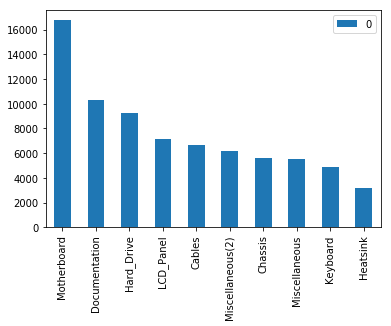

In [29]:
# Word count to find the total times we sent each individual part for these customers calling in.

def word_count(series):
    counts = dict()
    
    for i in range(0,len(series)):
        words = str(series[i]).split()
        for word in words:
            word = word.rstrip(',')
            word = word.rstrip('.')
            if word in counts:
                counts[word] += 1
            else:
                counts[word] = 1

    return counts

parts_snt = word_count(df['parts_sent'])

parts_df = pd.DataFrame.from_dict(parts_snt, orient='index')

#parts_df = parts_df.reset_index()
parts_df = parts_df.drop(index='-99999')

parts_df.sort_values(by=0,ascending=False).iloc[:10].plot(kind='bar')


Th above plot represents for the total number of parts sent for each individaul part for the customers in our data set. One thing to keep in mind for the above plot is there is a difference between Cables & Cables(2). Each would be treated as a unique part using the function I created above. Had I more time, this is something I would want to fix. 

This plot is plotting the top 10 origional parts sent to these customers. 

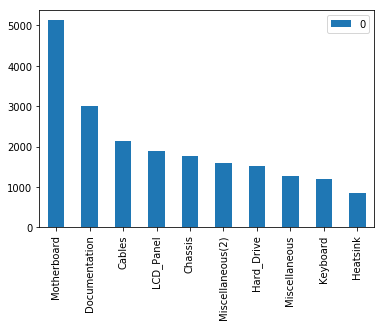

In [30]:
parts_snt = word_count(df['repeat_parts_sent'])

parts_df = pd.DataFrame.from_dict(parts_snt, orient='index')

#parts_df = parts_df.reset_index()
parts_df = parts_df.drop(index='-99999')

parts_df.sort_values(by=0,ascending=False).iloc[:10].plot(kind='bar')

This plot represents the same as the previous one, except this is for parts sent for follow up visits.

We can see the same individual parts are plotted, but in a different order. With more time, it would be good to standardize these numbers and then see which parts have a higher percentage of the total shipped in the additional parts graph than in the origional. THis would help identify which parts may be having issues and not just supportive parts (cables, documentation...) that would be required for any fix.

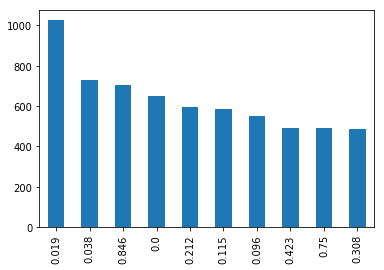

In [31]:
df['pct_complete_contract'].value_counts().iloc[:10].plot(kind='bar')

This plot provides the total count of customers calling in by the percentage of contract completion. We can see that the majority of the top 10 are customers calling in before they are 50% through their warranty. With the exception of ~700 that are 85% through and ~500 that are 75% through. The first two are customer that haven't even made it 10% through their contract period!

# Pivot Tables

The below groupby statements were mostly used to for EDA and demonstrate I can use them =]. 

In [32]:
df['count']=1
df.groupby(['product_type', 'repeat_ct'])[['count']].sum()

count
product_type      repeat_ct       
Desktops          0          22241
                  1           1360
Laptops           0          67233
                  1           5810
                  2              6
                  3              3
Other Electronics 0           3109
                  1            218

From this table I can see that Laptops require the most repeat visits. 

In [33]:
df.groupby(['repeat_ct', 'parts_ct'])[['count']].sum()

count
repeat_ct parts_ct       
0         0         44868
          1         22031
          2         11656
          3          7504
          4          3360
          5          1648
          6           702
          7           361
          8           216
          9            83
          10           73
          11           24
          12           24
          13           14
          14            9
          15            8
          16            2
          17            4
          18            3
          19            1
          20            3
          21            1
          28            1
          29            2
          46            1
          48            1
          50            1
          51            2
1         0           566
          1          2633
          2          2147
          3          1129
          4           508
          5           220
          6            91
          7            32
          8            20
          9            19
          10            7
          11            5
          12            3
          13            1
          14            1
          16            1
          18            3
          19            1
          20            1
2         5             1
          7             2
          8             1
          9             1
          10            1
3         5             2
          10            1

This table shows that for each additional vist less parts are required.

In [37]:
df.groupby(['contact_type','issue_type'])[['count']].sum()

count
contact_type issue_type                                             
-99999       Audio, Video, Speakers, TV Tuner                      2
             Customer Confirmed CID                                1
             Fee Based Support                                     5
             Information Status                                    2
             Operating System                                      1
             System Board Components                               3
CHAT         Adobe                                                21
             Audio, Video, Speakers, TV Tuner                   1852
             Backplane                                            63
             Backup / Archive / Data Management                    1
             Backup / Recovery Software                           11
             Battery / CMOS                                      604
             Battery/CMOS                                        119
             Burn, Playback, Audio                                 2
             CFA, MFA (Customer or Manufacturer) Field Action     13
             Communication/Networking                             13
             Compellent - NAS / zNAS / FS8600                      1
             Compellent - Non-Compellent                           1
             Contract or Service Issue                           169
             Controller / Controller Card                         36
             Credits                                              20
             Customer                                              1
             Customer Concession                                  18
             Customer Confirmed CID                               98
             Customer Related Issue                                9
             DDPE Locally Managed                                 10
             DDPE Remotely Managed                                13
             Dell EMC/EQL Software                                 2
             Dell Mobile / Wireless Devices                      110
             Dell Mobile Devices                                   7
...                                                              ...
VOICE        Media Only Dispatch                                 445
             Memory / Processor                                  667
             Microsoft Apps                                     1170
             Multiple Down Systems                                60
             Network Software                                      8
             Networking Hardware NICs / Switches                 674
             Never Shipped / Fulfilled                             1
             Non Dell Environment                                107
             Operating System                                   8946
             Optical Drive/Media Card Reader                     291
             Optical drive                                        92
             Order Tracking                                        3
             Power Subsystem / Cables / AC Adapter              4274
             Processing                                            3
             Projects Sales Concession                             9
             Projects Warranty                                     8
             Restricted                                          141
             Retail / Channel Returns                            202
             SC Storage SW (CML)                                   3
             Safety Hazard                                         8
             Security / Antivirus Software                       262
             Shipping Error / Factory Error                        3
             Stage                                                 9
             Sync Application Tile                                 7
             System Board Components                            9222
             System Out of Box                               

In [38]:
df.groupby(['region', 'issue_type'])[['count']].sum()

count
region    issue_type                                             
Hogwarts  Adobe                                               137
          Audio, Video, Speakers, TV Tuner                   5436
          Backplane                                           157
          Backup / Archive / Data Management                   16
          Backup / Recovery Software                          135
          Battery / CMOS                                     1433
          Battery/CMOS                                        423
          Burn, Playback, Audio                                94
          CFA, MFA (Customer or Manufacturer) Field Action     65
          Changed Mind                                         12
          Clinic                                               17
          Communication/Networking                            198
          Compellent - NAS / zNAS / FS8600                      1
          Compellent - Non-Compellent                           1
          Compellent - Software                                 1
          Contract or Service Issue                          1031
          Controller / Controller Card                        129
          Credits                                             226
          Customer                                              2
          Customer Concession                                 100
          Customer Confirmed CID                              353
          Customer Related Issue                              134
          DDPE Locally Managed                                 80
          DDPE Remotely Managed                                82
          Damaged                                               8
          Dell EMC/EQL Software                                11
          Dell Mobile / Wireless Devices                      496
          Dell Mobile Devices                                  54
          Dell Net Ready                                       14
          Dell OM Connection & Integration Packs                5
...                                                           ...
Milky Way Customer Related Issue                               11
          DDPE Locally Managed                                  3
          DDPE Remotely Managed                                 5
          Dell Mobile / Wireless Devices                       41
          Dell Mobile Devices                                   2
          Dell-Branded Apps (Other)                             2
          Document Request                                      6
          Fee Based Support                                   111
          Hard Drive                                          644
          Imaging Device                                       43
          Information Status                                  264
          Input Device / Webcam                               338
          Maintenance                                           2
          Mechanical Chassis / Rack                           258
          Media Only Dispatch                                  18
          Memory / Processor                                   35
          Microsoft Apps                                       24
          Networking Hardware NICs / Switches                  52
          Non Dell Environment                                  7
          Operating System                                    206
          Optical Drive/Media Card Reader                      20
          Optical drive                                         3
          Power Subsystem / Cables / AC Adapter               268
          Processing                                            2
          Restricted                                            2
          Security / Antivirus Software                         4
          System Board Components                            1538
          System Out of Box                                     2
          Tape Drive or Library   

In [39]:
df.groupby(['issue_type', 'repeat_ct'])[['count']].sum()

count
issue_type                                       repeat_ct       
Adobe                                            0            153
Audio, Video, Speakers, TV Tuner                 0           7657
                                                 1            834
                                                 2              1
Backplane                                        0            176
                                                 1             41
Backup / Archive / Data Management               0             21
Backup / Recovery Software                       0            199
Battery / CMOS                                   0           2094
                                                 1            249
Battery/CMOS                                     0            599
                                                 1              1
Burn, Playback, Audio                            0            108
CFA, MFA (Customer or Manufacturer) Field Action 0             79
                                                 1              9
Cancel & Rebook                                  0              4
Changed Mind                                     0             15
Clinic                                           0             24
Communication/Networking                         0            243
Compellent - Hardware                            1              2
Compellent - NAS / zNAS / FS8600                 0             17
Compellent - Non-Compellent                      0              3
Compellent - Software                            0              3
                                                 1              1
Contract or Service Issue                        0           3951
                                                 1             48
Controller / Controller Card                     0            234
                                                 1             36
Credits                                          0            226
                                                 1              4
...                                                           ...
Power Subsystem / Cables / AC Adapter            0           4486
                                                 1            694
                                                 2              1
                                                 3              1
Processing                                       0              3
Projects Sales Concession                        0              9
                                                 1              1
Projects Warranty                                0              8
Restricted                                       0            158
                                                 1              4
Retail / Channel Returns                         0            200
                                                 1              7
SC Storage SW (CML)                              0              3
Safety Hazard                                    0             10
Security / Antivirus Software                    0            281
Shipping Error / Factory Error                   0              3
Stage                                            0              7
                                                 1              2
Sync Application Tile                            0              8
System Board Components                          0          10927
                                                 1           2146
                                                 2              1
                                                 3              2
System Out of Box                                0             34
                                                 1              5
Systems Management                               0              6
Tape Drive or Library                            0             34
                                                 1              5
Try & Buy                         

In [40]:
df.groupby(['diagnostics', 'repair_type'])[['count']].sum()

count
diagnostics       repair_type       
Effective_Usage   Hard         15052
                  Soft          7760
InEffective_Usage Hard          6324
                  Soft           914
Not_Considered    Hard           542
                  Soft          1943
Not_USED          Hard         37577
                  Soft         29888

With this Data, it would be nice to know the time associated with each call, maybe even the average time associated with each additional visit. This would give use a wayt to prioritize which problems should be researched/fixed first. Also the money associated with the different levels of tenure for the agents. This would give us the ability to associate cost savings if we could implent certain solutions. This would be great information to have on hand to help influence decision makers to use these solutions.